# Genre Classification

## 1 Introduction

### 1.1 Environment Setup

In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve # ROC Curves
from sklearn.metrics import auc # Calculating AUC for ROC's!
from matplotlib import pyplot as plt

### 1.2 Loading the Data

In [2]:
# load in song data
country = pd.read_csv("/Users/candacemckeag/Documents/School/datasci/country.csv")
metal = pd.read_csv("/Users/candacemckeag/Documents/School/datasci/metal.csv")
rap = pd.read_csv("/Users/candacemckeag/Documents/School/datasci/rap.csv")
country['genre'] = 'country'
metal['genre'] = 'metal'
rap['genre'] = 'rap'
songs = pd.concat([country, metal, rap])
songs = songs.drop(['title','artist'],1)

In [ ]:
allFeatures = ["danceability", "energy", "key", "loudness", "mode", "speechiness", "acousticness",
				 "instrumentalness", "liveness", "valence", "tempo"]

### 1.3 General Function Definitions

The function *splitDataFrame* receives the song data and feature names, and then proceeds to split the data into training and testing sets along with separating the correct values.

In [41]:
# split dataframe into training and testing sets
def splitDataFrame(songsdf, features):
	df = pd.DataFrame(songsdf)
	#normalize data
	train, test = train_test_split(df, test_size = 0.2, random_state=7)
	std_scale = preprocessing.MinMaxScaler().fit(train[features])
	train_trans = std_scale.fit_transform(train[features])
	training_set = pd.DataFrame(train_trans, columns = features)
	target = train['genre']
	test_trans =  std_scale.transform(test[features])
	test_set = pd.DataFrame(test_trans, columns = features)
	test_target = test['genre']
	return training_set, test_set, target, test_target

The function *PCAOnDataFrame* is used to perform Principal Component Analysis on the training and testing sets. It returns the transformed training and testing sets along with a column of the component indices.

In [42]:
# perform PCA on training and testing set
def PCAOnDataFrame(training_set, test_set, features, components):
	pca = PCA(n_components=components, random_state=7)
	pca.fit(training_set[features])
	training_set_pca = pca.fit_transform(training_set[features])
	components_col = [x for x in range(0, components)]
	training_set = pd.DataFrame(training_set_pca, columns = components_col)
	test_set_pca = pca.transform(test_set[features])
	test_set = pd.DataFrame(test_set_pca, columns = components_col)
	return training_set, test_set, components_col

## 2 Model Building

### 2.1 K-Nearest-Neighbors

#### 2.1.1 Data Setup

We begin by defining a function *predictGenreKNN* which performs KNN classification on a dataset using the user-defined number of neighbors. We split the data into a training and testing set.

In [43]:
# use KNN to predict category
def predictGenreKNN(training_set, test_set,  target, test_target, componentsList, k):
	classifier = KNeighborsClassifier(n_neighbors=k, metric='minkowski')
	classifier.fit(training_set[componentsList], target)
	return test_set, classifier.predict(test_set[componentsList]), test_target, classifier.score(test_set[componentsList], test_target)

In [71]:
# split data
training_set_knn, test_set_knn, target_knn, test_target_knn = splitDataFrame(songs, allFeatures)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning:

Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning:

Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.



#### 2.1.2 Data Preprocessing

We perform the Principal Component Analysis transformation iteratively in order to find the optimal number of components to use.

In [151]:
knnpcascores = []
for i in range(1,12):
    training_set, test_set, components_col = PCAOnDataFrame(training_set_knn, test_set_knn, allFeatures, i)
    testdf, predictions, correctValues, score = predictGenreKNN(training_set, test_set, target, test_target, components_col, 10)
    knnpcascores.append(score)

In [152]:
bestknnpca = np.argmax(knnpcascores) + 1
bestknnpca

9

We see that using 9 components is optimal, so we will proceed with this transformation in building our model.

In [73]:
training_set_knnpca, test_set_knnpca, components_col_knn = PCAOnDataFrame(training_set_knn, test_set_knn, allFeatures, bestknnpca)

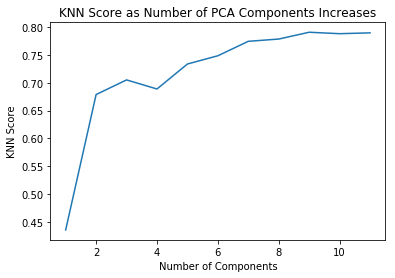

In [74]:
plt.title('KNN Score as Number of PCA Components Increases')
plt.plot(np.arange(1,12), knnpcascores)
plt.xlabel('Number of Components')
plt.ylabel('KNN Score')
plt.show()

#### 2.1.3 Parameter Tuning

We iteratively build models in order to find the optimal number of neighbors which maximizes the model score.

In [77]:
# find optimal number of neighbors
kscores = []
for i in range(1,100):
    testdf, predictions, correctValues, score = predictGenreKNN(training_set_knnpca, test_set_knnpca, target_knn, test_target_knn, components_col_knn, i)
    kscores.append(score)

In [78]:
# assign to bestk
bestk = np.argmax(kscores) + 1
bestk

14

We can see here that using 14 neighbors in our classifier optimizes the predictions. 

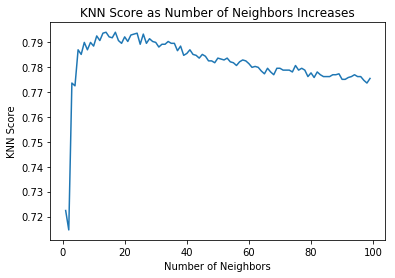

In [81]:
plt.title('KNN Score as Number of Neighbors Increases')
plt.plot(np.arange(1,100), kscores)
plt.xlabel('Number of Neighbors')
plt.ylabel('KNN Score')
plt.show()

#### 2.1.4 Best Model

In [130]:
KNN = KNeighborsClassifier(n_neighbors=bestk, metric='minkowski')

The best k-nearest-neighbors model is trained on the PCA-transformed dataset with 9 components and uses 14 neighbors in classification.

### 2.2 Random Forest

#### 2.2.1 Data Setup

In [82]:
# use Random Forest to predict category
def predictGenreRF(training_set, test_set,  target, test_target, componentsList, ntree):
	classifier = RandomForestClassifier(n_estimators = ntree)
	classifier.fit(training_set[componentsList], target)
	return test_set, classifier.predict(test_set[componentsList]), test_target, classifier.score(test_set[componentsList], test_target)

In [83]:
# split data
training_set_rf, test_set_rf, target_rf, test_target_rf = splitDataFrame(songs, allFeatures)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning:

Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning:

Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.



#### 2.2.2 Data Preprocessing

In [86]:
rfpcascores = []
for i in range(1,12):
    training_set, test_set, components_col = PCAOnDataFrame(training_set_knn, test_set_knn, allFeatures, i)
    testdf, predictions, correctValues, score = predictGenreRF(training_set, test_set, target, test_target, components_col, 100)
    rfpcascores.append(score)

In [87]:
bestrfpca = np.argmax(rfpcascores) + 1
bestrfpca

11

In [88]:
training_set_rfpca, test_set_rfpca, components_col_rf = PCAOnDataFrame(training_set_rf, test_set_rf, allFeatures, bestrfpca)

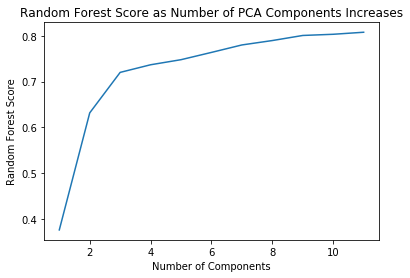

In [178]:
plt.title('Random Forest Score as Number of PCA Components Increases')
plt.plot(np.arange(1,12), rfpcascores)
plt.xlabel('Number of Components')
plt.ylabel('Random Forest Score')
plt.show()

#### 2.2.3 Parameter Tuning

In [89]:
# find optimal number of trees
treescores = []
for i in range(50,150):
    testdf, predictions, correctValues, score = predictGenreRF(training_set_rfpca, test_set_rfpca, target_rf, test_target_rf, components_col_rf, i)
    treescores.append(score)

In [91]:
# assign to besttree
besttree = np.argmax(treescores) + 50
besttree

147

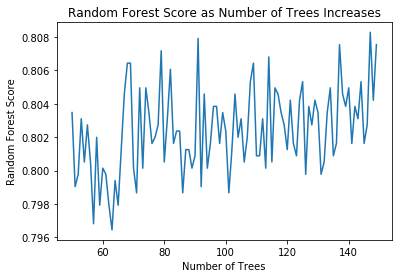

In [92]:
plt.title('Random Forest Score as Number of Trees Increases')
plt.plot(np.arange(50,150), treescores)
plt.xlabel('Number of Trees')
plt.ylabel('Random Forest Score')
plt.show()

#### 2.2.4 Best Model

In [131]:
RF = RandomForestClassifier(n_estimators = besttree)

### 2.3 Logistic Regression

#### 2.3.1 Data Setup

In [108]:
# use Logistic Regression to predict category
def predictGenreLog(training_set, test_set,  target, test_target, componentsList, c):
	classifier = LogisticRegression(multi_class='multinomial', solver='lbfgs', C=c)
	classifier.fit(training_set[componentsList], target)
	return test_set, classifier.predict(test_set[componentsList]), test_target, classifier.score(test_set[componentsList], test_target)

In [94]:
# split data
training_set_log, test_set_log, target_log, test_target_log = splitDataFrame(songs, allFeatures)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning:

Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning:

Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.



#### 2.3.2 Data Preprocessing

In [98]:
logpcascores = []
for i in range(1,12):
    training_set, test_set, components_col = PCAOnDataFrame(training_set_log, test_set_log, allFeatures, i)
    testdf, predictions, correctValues, score = predictGenreLog(training_set, test_set, target, test_target, components_col, c=1.0)
    logpcascores.append(score)

In [99]:
bestlogpca = np.argmax(logpcascores) + 1
bestlogpca

11

In [100]:
training_set_logpca, test_set_logpca, components_col_log = PCAOnDataFrame(training_set_log, test_set_log, allFeatures, bestlogpca)

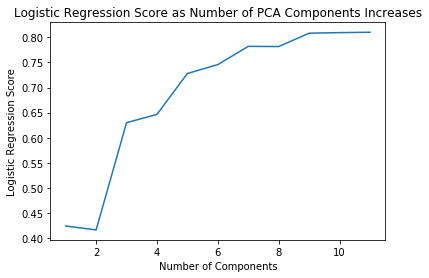

In [101]:
plt.title('Logistic Regression Score as Number of PCA Components Increases')
plt.plot(np.arange(1,12), logpcascores)
plt.xlabel('Number of Components')
plt.ylabel('Logistic Regression Score')
plt.show()

#### 2.3.3 Parameter Tuning

In [110]:
# find optimal regularization strength
cscores = []
for i in np.arange(0.1, 10.0, 0.1):
    testdf, predictions, correctValues, score = predictGenreLog(training_set_logpca, test_set_logpca, target_log, test_target_log, components_col_log, i)
    cscores.append(score)

In [113]:
# assign to bestc
bestc = np.argmax(cscores)/10 + 0.1
bestc

1.6

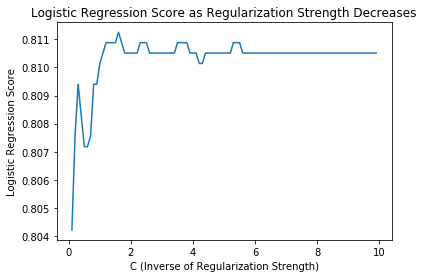

In [115]:
plt.title('Logistic Regression Score as Regularization Strength Decreases')
plt.plot(np.arange(0.1, 10.0, 0.1), cscores)
plt.xlabel('C (Inverse of Regularization Strength)')
plt.ylabel('Logistic Regression Score')
plt.show()

#### 2.3.4 Best Model

In [172]:
LOG = LogisticRegression(multi_class='multinomial', solver='lbfgs', C=bestc, max_iter=2000)

### 2.4 Gradient Boosting

#### 2.4.1 Data Setup

In [117]:
# use Logistic Regression to predict category
def predictGenreGB(training_set, test_set,  target, test_target, componentsList, n):
	classifier = GradientBoostingClassifier(n_estimators=n)
	classifier.fit(training_set[componentsList], target)
	return test_set, classifier.predict(test_set[componentsList]), test_target, classifier.score(test_set[componentsList], test_target)

In [118]:
# split data
training_set_gb, test_set_gb, target_gb, test_target_gb = splitDataFrame(songs, allFeatures)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning:

Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning:

Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.



#### 2.4.2 Data Preprocessing

In [119]:
gbpcascores = []
for i in range(1,12):
    training_set, test_set, components_col = PCAOnDataFrame(training_set_gb, test_set_gb, allFeatures, i)
    testdf, predictions, correctValues, score = predictGenreGB(training_set, test_set, target, test_target, components_col, n=100)
    gbpcascores.append(score)

In [120]:
bestgbpca = np.argmax(gbpcascores) + 1
bestgbpca

10

In [121]:
training_set_gbpca, test_set_gbpca, components_col_gb = PCAOnDataFrame(training_set_gb, test_set_gb, allFeatures, bestgbpca)

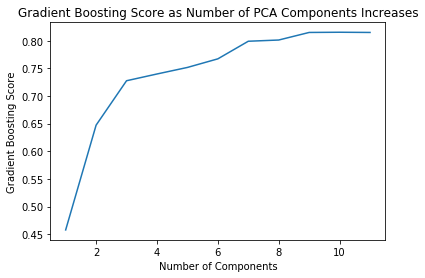

In [122]:
plt.title('Gradient Boosting Score as Number of PCA Components Increases')
plt.plot(np.arange(1,12), gbpcascores)
plt.xlabel('Number of Components')
plt.ylabel('Gradient Boosting Score')
plt.show()

#### 2.4.3 Parameter Tuning

In [123]:
# find optimal number of boosting stages
nscores = []
for i in range(75,150):
    testdf, predictions, correctValues, score = predictGenreGB(training_set_gbpca, test_set_gbpca, target_gb, test_target_gb, components_col_gb, i)
    nscores.append(score)

In [124]:
# assign to bestn
bestn = np.argmax(nscores) + 75
bestn

148

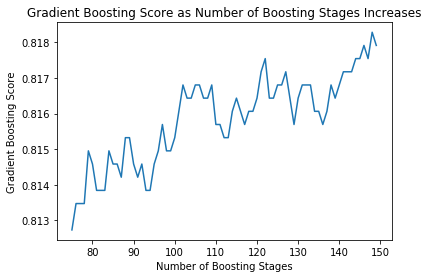

In [125]:
plt.title('Gradient Boosting Score as Number of Boosting Stages Increases')
plt.plot(np.arange(75,150), nscores)
plt.xlabel('Number of Boosting Stages')
plt.ylabel('Gradient Boosting Score')
plt.show()

#### 2.4.4 Best Model

In [133]:
GB = GradientBoostingClassifier(n_estimators = bestn)

## 3 Model Comparison

### 3.1 Cross-Validation

We perform cross-validation on the best version of each algorithm and choose the model with the lowest test error.

In [146]:
# perform PCA on training and testing set
def cvPCA(fullset, features, components):
	pca = PCA(n_components=components, random_state=7)
	pca.fit(fullset[features])
	fullset_pca = pca.fit_transform(fullset[features])
	components_col = [x for x in range(0, components)]
	target = fullset['genre']
	fullset = pd.DataFrame(fullset_pca, columns = components_col)
	return fullset, target, components_col

#### 3.1.1 K-Nearest-Neighbors

In [153]:
full_knnpca, target_knnpca, components_col_knn = cvPCA(songs, allFeatures, bestknnpca)

In [160]:
sck = cross_val_score(KNN, full_knnpca, target_knnpca, cv=10)

In [162]:
print("Accuracy: %0.2f (+/- %0.2f)" % (sck.mean(), sck.std() * 2))

Accuracy: 0.50 (+/- 0.02)


#### 3.1.2 Random Forest

In [163]:
full_rfpca, target_rfpca, components_col_rf = cvPCA(songs, allFeatures, bestrfpca)

In [164]:
scrf = cross_val_score(RF, full_rfpca, target_rfpca, cv=10)

In [165]:
print("Accuracy: %0.2f (+/- %0.2f)" % (scrf.mean(), scrf.std() * 2))

Accuracy: 0.80 (+/- 0.03)


#### 3.1.3 Logistic Regression

In [166]:
full_logpca, target_logpca, components_col_log = cvPCA(songs, allFeatures, bestlogpca)

In [173]:
sclog = cross_val_score(LOG, full_logpca, target_logpca, cv=10)

In [174]:
print("Accuracy: %0.2f (+/- %0.2f)" % (sclog.mean(), sclog.std() * 2))

Accuracy: 0.81 (+/- 0.02)


#### 3.1.3 Gradient Boosting

In [175]:
full_gbpca, target_gbpca, components_col_gb = cvPCA(songs, allFeatures, bestgbpca)

In [176]:
scgb = cross_val_score(GB, full_gbpca, target_gbpca, cv=10)

In [177]:
print("Accuracy: %0.2f (+/- %0.2f)" % (scgb.mean(), scgb.std() * 2))

Accuracy: 0.82 (+/- 0.03)


### 3.2 Model Choice

Since the Gradient Boosting model has the highest accuracy, we will use this model moving forward.